# Electricity Consumption Prediction using RNN vs LSTM vs GRU

In [2]:
!pip install torchmetrics

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torchmetrics import MeanSquaredError

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

## EDA

In [4]:
train_data = pd.read_csv('/content/electricity_train.csv')
test_data = pd.read_csv('/content/electricity_test.csv')

train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

In [5]:
train_data.head()

,timestamp,consumption
0,2011-01-01 00:15:00,-0.704319
1,2011-01-01 00:30:00,-0.704319
2,2011-01-01 00:45:00,-0.678983
3,2011-01-01 01:00:00,-0.653647
4,2011-01-01 01:15:00,-0.704319


In [6]:
print(train_data.duplicated().sum())
print(train_data['timestamp'].isna().sum())

0
0


### Exploring Time Features

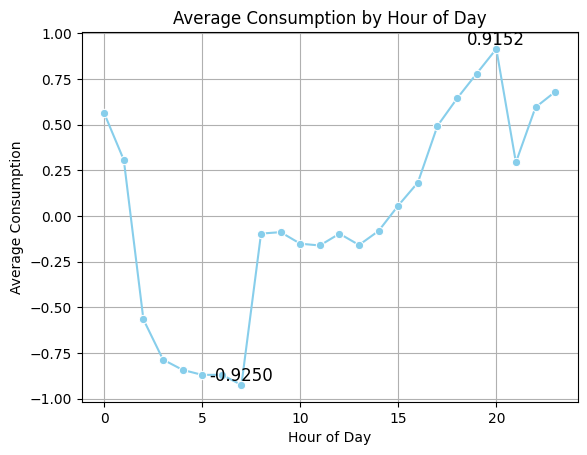

In [7]:
train_data['hour'] = train_data['timestamp'].dt.hour
hour_consumption = train_data.groupby('hour')['consumption'].mean()

highest = hour_consumption.max()
lowest = hour_consumption.min()

highest_hour = hour_consumption.idxmax()
lowest_hour = hour_consumption.idxmin()

sns.lineplot(x=hour_consumption.index, y=hour_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption')
plt.grid()

plt.text(highest_hour, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_hour, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

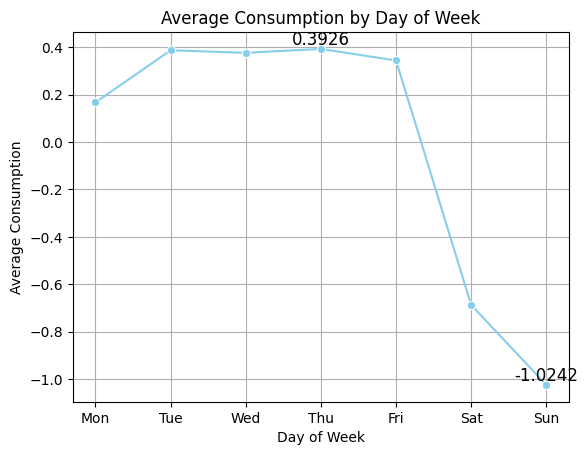

In [8]:
train_data['day_of_week'] = train_data['timestamp'].dt.dayofweek
day_of_week_consumption = train_data.groupby('day_of_week')['consumption'].mean()

highest = day_of_week_consumption.max()
lowest = day_of_week_consumption.min()

highest_day_of_week = day_of_week_consumption.idxmax()
lowest_day_of_week = day_of_week_consumption.idxmin()

sns.lineplot(x=day_of_week_consumption.index, y=day_of_week_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Consumption')
plt.grid()

plt.xticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.text(highest_day_of_week, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_day_of_week, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

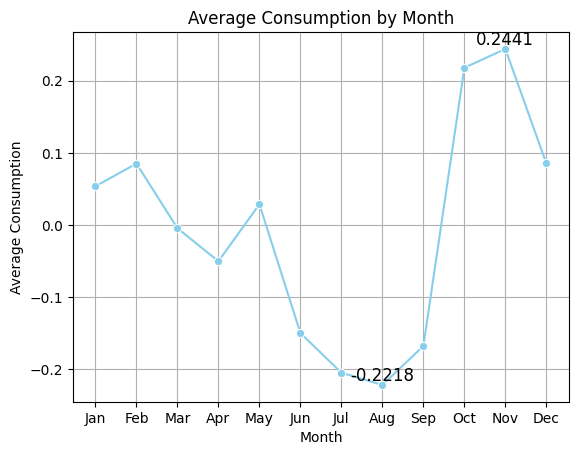

In [9]:
train_data['month'] = train_data['timestamp'].dt.month
month_consumption = train_data.groupby('month')['consumption'].mean()

highest = month_consumption.max()
lowest = month_consumption.min()

highest_month = month_consumption.idxmax()
lowest_month = month_consumption.idxmin()

sns.lineplot(x=month_consumption.index, y=month_consumption.values, marker='o', color='skyblue')
plt.title('Average Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Consumption')
plt.grid()

plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.text(highest_month, highest, s=f'{highest:.4f}', fontsize=12, ha='center', va='bottom')
plt.text(lowest_month, lowest, s=f'{lowest:.4f}', fontsize=12, ha='center', va='bottom')

plt.show()

## Prepare Data

My features are past electricity comsumption in 24 hours = 4 * 24 = 96

In [10]:
def create_sequences(df, seq_length):
		xs, ys = [], []
		for i in range(len(df) - seq_length):
				x = df.iloc[i:(i+seq_length), 1]
				y = df.iloc[i+seq_length, 1]
				xs.append(x)
				ys.append(y)
		return np.array(xs), np.array(ys)

seq_length = 24*4

X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [11]:
print(f'Shape of Train data: {X_train.shape}, {y_train.shape}')
print(f'Shape of Test data: {X_test.shape}, {y_test.shape}')

Shape of Train data: (105119, 96), (105119,)
Shape of Test data: (34944, 96), (34944,)


In [12]:
dataset_train_val = TensorDataset(
		torch.from_numpy(X_train).float(),
		torch.from_numpy(y_train).float()
)

dataset_test = TensorDataset(
		torch.from_numpy(X_test).float(),
		torch.from_numpy(y_test).float()
)

In [13]:
train_size = int(0.9 * len(dataset_train_val))
val_size = len(dataset_train_val) - train_size
train_dataset, val_dataset = random_split(dataset_train_val, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle = True)
test_loader = DataLoader(dataset_test, batch_size=16, shuffle = True)

## Data Prediction

### Setting Training and Validation Loop

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [15]:
def train_and_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs, patience, device):
    # Early stopping and best model state initialization
    min_val_loss = float('inf')
    count = 0
    best_model_state = None

    # Store training and validation losses
    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0.0

        # Training Phase
        for seqs, labels in train_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            optimizer.zero_grad()
            seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

            outputs = model(seqs)
            loss = criterion(outputs, labels.view(-1, 1))

            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        epoch_train_loss = training_loss / len(train_loader)
        train_loss.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        validation_loss = 0.0

        with torch.no_grad():
            for seqs, labels in val_loader:
                seqs, labels = seqs.to(device), labels.to(device)
                seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)

                outputs = model(seqs)
                loss = criterion(outputs, labels.view(-1, 1))
                validation_loss += loss.item()

        epoch_val_loss = validation_loss / len(val_loader)
        val_loss.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping
        if epoch_val_loss < min_val_loss:
            min_val_loss = epoch_val_loss
            count = 0
            best_epoch = epoch
            best_model_state = model.state_dict()
        else:
            count += 1
            if count >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}. Best Val Loss: {min_val_loss:.4f} at Epoch: {best_epoch+1}/{num_epochs}")
                break

    return best_model_state, train_loss, val_loss

### Setting Graph Plotting for Training and Validation Loss

In [16]:
def plot_loss_curve(train_loss, val_loss, num_epochs, model_name="Model"):
    mean_train_loss = sum(train_loss) / len(train_loss)
    mean_val_loss = sum(val_loss) / len(val_loss)

    range_epoch = len(train_loss)

    # Plot the Loss Curve
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, range_epoch + 1), train_loss, label=f'Training Loss (Mean: {mean_train_loss:.4f})', marker='o')
    plt.plot(range(1, range_epoch + 1), val_loss, label=f'Validation Loss (Mean: {mean_val_loss:.4f})', marker='s')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{model_name}: Training & Validation Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

### Setting Testing Loop

In [17]:
def compute_test_mse(model, test_loader, device):
    mse_metric = MeanSquaredError().to(device)

    model.eval()
    total_mse = 0.0

    with torch.no_grad():
        for seqs, labels in test_loader:
            seqs, labels = seqs.to(device), labels.to(device)
            seqs = seqs.view(seqs.shape[0], seqs.shape[1], 1)
            outputs = model(seqs).squeeze()

            mse_metric.update(outputs, labels) # accumulate

    test_mse = mse_metric.compute() # average

    return test_mse.item()

### RNN

In [18]:
class Net_RNN(nn.Module):
		def __init__(self):
				super().__init__()
				self.rnn = nn.RNN(
						input_size = 1, # 1 feature
						hidden_size = 32,
						num_layers = 2,
						batch_first = True,
				)
				self.fc = nn.Linear(32, 1)

		def forward(self, x):
				h0 = torch.zeros(self.rnn.num_layers, x.size(0), 32).to(x.device) # initialize first hidden state to zeros
				out, _ = self.rnn(x, h0)
				out = self.fc(out[:, -1, :]) # select last RNN's output and pass it through linear layer
				return out

net_RNN = Net_RNN().to(device)

In [19]:
criterion = nn.MSELoss()
optimizer_RNN = optim.Adam(net_RNN.parameters(), lr=0.0001)

In [20]:
# Early stopping parameters
patience = 5 # Number of epochs to wait before stopping

# epoch
num_epochs_RNN = 20

In [21]:
best_model_RNN, train_loss_RNN, val_loss_RNN = train_and_validate_model(
    model=net_RNN,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_RNN,
    criterion=criterion,
    num_epochs=num_epochs_RNN,
    patience=patience,
    device=device
)

Epoch 1/20 - Train Loss: 0.0941, Val Loss: 0.0572
Epoch 2/20 - Train Loss: 0.0581, Val Loss: 0.0561
Epoch 3/20 - Train Loss: 0.0566, Val Loss: 0.0536
Epoch 4/20 - Train Loss: 0.0546, Val Loss: 0.0519
Epoch 5/20 - Train Loss: 0.0527, Val Loss: 0.0506
Epoch 6/20 - Train Loss: 0.0512, Val Loss: 0.0495
Epoch 7/20 - Train Loss: 0.0501, Val Loss: 0.0485
Epoch 8/20 - Train Loss: 0.0491, Val Loss: 0.0484
Epoch 9/20 - Train Loss: 0.0485, Val Loss: 0.0477
Epoch 10/20 - Train Loss: 0.0479, Val Loss: 0.0470
Epoch 11/20 - Train Loss: 0.0474, Val Loss: 0.0468
Epoch 12/20 - Train Loss: 0.0469, Val Loss: 0.0465
Epoch 13/20 - Train Loss: 0.0465, Val Loss: 0.0468
Epoch 14/20 - Train Loss: 0.0460, Val Loss: 0.0460
Epoch 15/20 - Train Loss: 0.0455, Val Loss: 0.0457
Epoch 16/20 - Train Loss: 0.0451, Val Loss: 0.0455
Epoch 17/20 - Train Loss: 0.0449, Val Loss: 0.0455
Epoch 18/20 - Train Loss: 0.0445, Val Loss: 0.0451
Epoch 19/20 - Train Loss: 0.0446, Val Loss: 0.0454
Epoch 20/20 - Train Loss: 0.0442, Val Lo

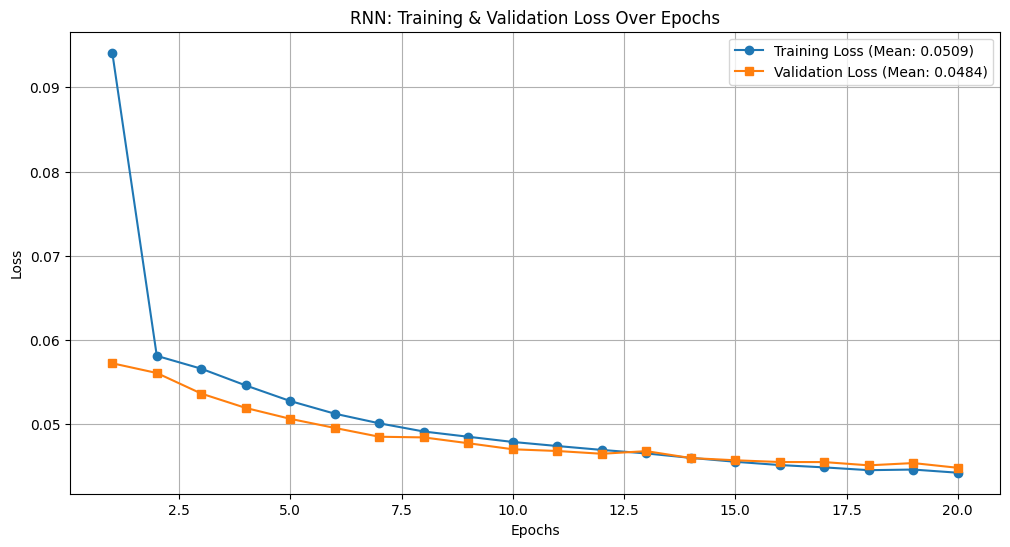

In [22]:
plot_loss_curve(train_loss_RNN, val_loss_RNN, num_epochs_RNN, model_name="RNN")

In [23]:
if best_model_RNN:
    net_RNN.load_state_dict(best_model_RNN)

In [24]:
test_mse_RNN = compute_test_mse(net_RNN, test_loader, device)
print(f"Test MSE: {test_mse_RNN:.4f}")

Test MSE: 0.0426


### LSTM

In [25]:
class Net_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,  # 1 feature
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), self.lstm.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_LSTM = Net_LSTM().to(device)

In [26]:
optimizer_LSTM = optim.Adam(net_LSTM.parameters(), lr=0.0001)

In [27]:
# Early stopping parameters
patience = 5

# epoch
num_epochs_LSTM = 20

In [28]:
best_model_LSTM, train_loss_LSTM, val_loss_LSTM = train_and_validate_model(
    model=net_LSTM,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_LSTM,
    criterion=criterion,
    num_epochs=num_epochs_RNN,
    patience=patience,
    device=device
)

Epoch 1/20 - Train Loss: 0.1747, Val Loss: 0.0607
Epoch 2/20 - Train Loss: 0.0667, Val Loss: 0.0530
Epoch 3/20 - Train Loss: 0.0588, Val Loss: 0.0509
Epoch 4/20 - Train Loss: 0.0553, Val Loss: 0.0490
Epoch 5/20 - Train Loss: 0.0525, Val Loss: 0.0493
Epoch 6/20 - Train Loss: 0.0504, Val Loss: 0.0464
Epoch 7/20 - Train Loss: 0.0486, Val Loss: 0.0462
Epoch 8/20 - Train Loss: 0.0475, Val Loss: 0.0449
Epoch 9/20 - Train Loss: 0.0464, Val Loss: 0.0448
Epoch 10/20 - Train Loss: 0.0453, Val Loss: 0.0434
Epoch 11/20 - Train Loss: 0.0444, Val Loss: 0.0439
Epoch 12/20 - Train Loss: 0.0438, Val Loss: 0.0423
Epoch 13/20 - Train Loss: 0.0436, Val Loss: 0.0426
Epoch 14/20 - Train Loss: 0.0432, Val Loss: 0.0426
Epoch 15/20 - Train Loss: 0.0428, Val Loss: 0.0422
Epoch 16/20 - Train Loss: 0.0425, Val Loss: 0.0415
Epoch 17/20 - Train Loss: 0.0423, Val Loss: 0.0414
Epoch 18/20 - Train Loss: 0.0418, Val Loss: 0.0414
Epoch 19/20 - Train Loss: 0.0416, Val Loss: 0.0408
Epoch 20/20 - Train Loss: 0.0414, Val Lo

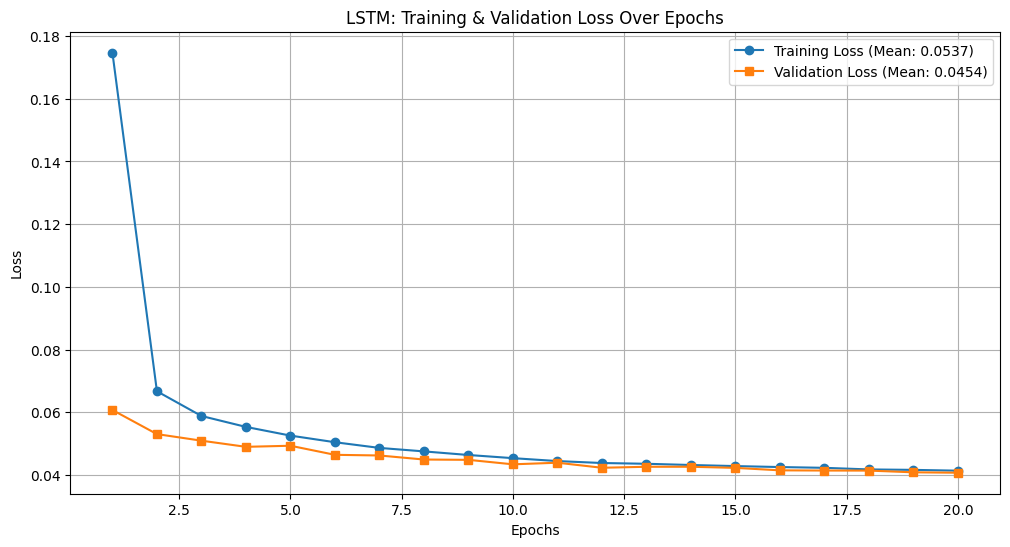

In [29]:
plot_loss_curve(train_loss_LSTM, val_loss_LSTM, num_epochs_RNN, model_name="LSTM")

In [30]:
if best_model_LSTM:
    net_LSTM.load_state_dict(best_model_LSTM)

In [31]:
test_mse_LSTM = compute_test_mse(net_LSTM, test_loader, device)
print(f"Test MSE: {test_mse_LSTM:.4f}")

Test MSE: 0.0567


### GRU

In [32]:
class Net_GRU(nn.Module):
    def __init__(self):
        super().__init__()
        self.gru = nn.GRU(
            input_size=1,  # 1 feature
            hidden_size=32,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), self.gru.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

net_GRU = Net_GRU().to(device)

In [33]:
optimizer_GRU = optim.Adam(net_GRU.parameters(), lr=0.0001)

In [34]:
# Early stopping parameters
patience = 5

# epoch
num_epochs_GRU = 20

In [35]:
best_model_GRU, train_loss_GRU, val_loss_GRU = train_and_validate_model(
    model=net_GRU,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_GRU,
    criterion=criterion,
    num_epochs=num_epochs_RNN,
    patience=patience,
    device=device
)

Epoch 1/20 - Train Loss: 0.1282, Val Loss: 0.0569
Epoch 2/20 - Train Loss: 0.0654, Val Loss: 0.0556
Epoch 3/20 - Train Loss: 0.0615, Val Loss: 0.0539
Epoch 4/20 - Train Loss: 0.0592, Val Loss: 0.0524
Epoch 5/20 - Train Loss: 0.0569, Val Loss: 0.0516
Epoch 6/20 - Train Loss: 0.0554, Val Loss: 0.0502
Epoch 7/20 - Train Loss: 0.0537, Val Loss: 0.0492
Epoch 8/20 - Train Loss: 0.0523, Val Loss: 0.0483
Epoch 9/20 - Train Loss: 0.0511, Val Loss: 0.0478
Epoch 10/20 - Train Loss: 0.0502, Val Loss: 0.0478
Epoch 11/20 - Train Loss: 0.0493, Val Loss: 0.0478
Epoch 12/20 - Train Loss: 0.0486, Val Loss: 0.0463
Epoch 13/20 - Train Loss: 0.0481, Val Loss: 0.0460
Epoch 14/20 - Train Loss: 0.0473, Val Loss: 0.0461
Epoch 15/20 - Train Loss: 0.0468, Val Loss: 0.0455
Epoch 16/20 - Train Loss: 0.0466, Val Loss: 0.0455
Epoch 17/20 - Train Loss: 0.0459, Val Loss: 0.0450
Epoch 18/20 - Train Loss: 0.0455, Val Loss: 0.0480
Epoch 19/20 - Train Loss: 0.0452, Val Loss: 0.0445
Epoch 20/20 - Train Loss: 0.0449, Val Lo

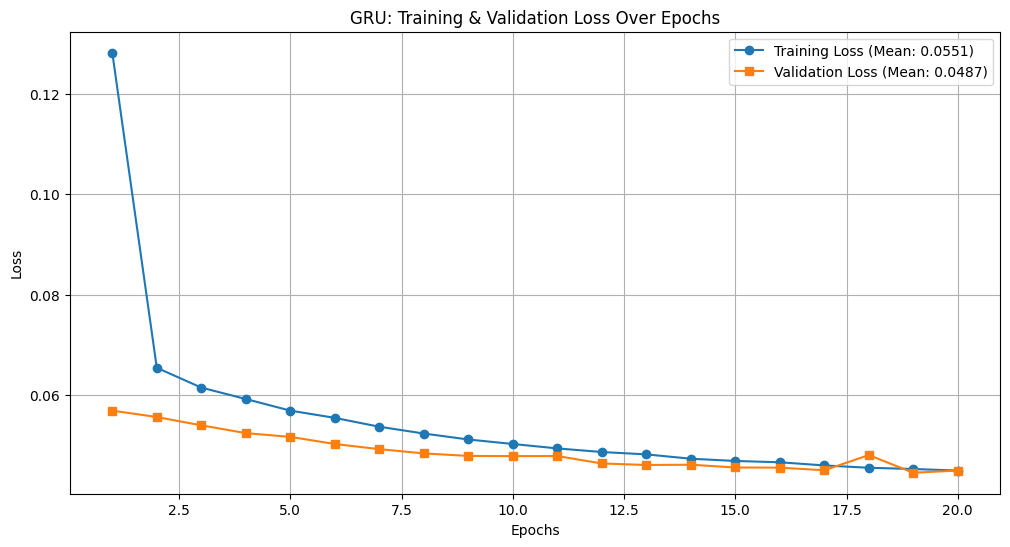

In [36]:
plot_loss_curve(train_loss_GRU, val_loss_GRU, num_epochs_RNN, model_name="GRU")

In [37]:
if best_model_GRU:
    net_GRU.load_state_dict(best_model_GRU)

In [38]:
test_mse_GRU = compute_test_mse(net_GRU, test_loader, device)
print(f"Test MSE: {test_mse_GRU:.4f}")

Test MSE: 0.0412
